In [32]:
from config import *
from model import *
from train import *

In [33]:
argparser = argparse.ArgumentParser()
# [general config of the training]
argparser.add_argument("--phase",                   default = "0")
argparser.add_argument("--device",                  default = config.device)
argparser.add_argument("--name",                    default = "KFT")
argparser.add_argument("--epoch",                   default = 400 * 3)
argparser.add_argument("--optimizer",               default = "Adam")
argparser.add_argument("--lr",                      default = 2e-4)
argparser.add_argument("--batch_size",              default = 1)
argparser.add_argument("--dataset",                 default = "StructureNet")
argparser.add_argument("--category",                default = ["chair"])
argparser.add_argument("--freeze_perception",       default = False)
argparser.add_argument("--concept_type",            default = False)

# [perception and language grounding training]
argparser.add_argument("--perception",              default = "csqnet")
argparser.add_argument("--training_mode",           default = "joint")
argparser.add_argument("--alpha",                   default = 1.00)
argparser.add_argument("--beta",                    default = 1.0)

# [additional training details]
argparser.add_argument("--warmup",                  default = True)
argparser.add_argument("--warmup_steps",            default = 300)
argparser.add_argument("--decay",                   default = False)
argparser.add_argument("--decay_steps",             default = 20000)
argparser.add_argument("--decay_rate",              default = 0.99)
argparser.add_argument("--shuffle",                 default = True)

# [curriculum training details]
argparser.add_argument("--effective_level",         default = 1)

# [checkpoint location and savings]
argparser.add_argument("--checkpoint_dir",          default = False)
argparser.add_argument("--checkpoint_itrs",         default = 10,       type=int)
argparser.add_argument("--pretrain_perception",     default = False)

args = argparser.parse_args(args = [])

In [62]:
# [Data Preparation]
from datasets import Objects3dDataset, StructureDataset, StructureGroundingDataset
dataset = StructureDataset(config, "chair", "train",)
dataset = StructureGroundingDataset(config, "table", "train", "3")

loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle = True)
for sample in loader:
    sample,gt = sample
    break;

StructureGrouding Net with  table


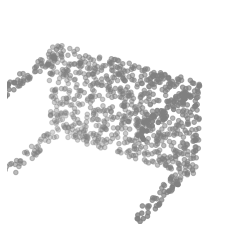

In [63]:
visualize_pointcloud([
    [sample["point_cloud"][0] * 2, 0.5 * torch.ones_like(sample["point_cloud"][0] ) ]
])

torch.Size([1, 3000, 3])
torch.Size([1, 3000, 3])
torch.Size([1, 3000, 1])


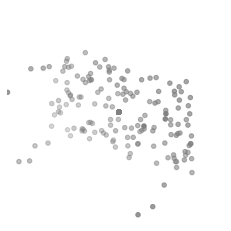

In [64]:
coords = sample["coords"]
colors = sample["coord_color"]
occs = sample["occ"]

print(coords.shape)
print(colors.shape)
print(occs.shape)

visualize_pointcloud([
    [ 2* coords[0] * occs[0],colors[0]]
])


In [36]:
model = Halearner(config)
#print(model.perception)

/Users/melkor/Documents/GitHub/Hierarchical-Learner/HierarchyLearner/knowledge/structure_chair_concept_vocab.txt


In [37]:
# [Train Backbone]
outputs = model.perception(sample)

loss = outputs["losses"]
#print(loss["occ_reconstruction"])
#print(loss["color_reconstruction"])
#print(outputs)
#print(outputs["features"].shape)
#print(outputs["occ"].shape)

def load_scene(scene, k): 
    scores = scene["scores"]; features = scene["features"]; connections = scene["connections"]
    return [score[k] for score in scores], [feature[k] for feature in features], \
        [connection[k] for connection in connections[1:]]

base_features = outputs["features"]

obj_map = nn.Linear(1025,100)

base_features = obj_map(base_features)

scene_struct = model.build_scene(base_features)

scores,features,connections = load_scene(scene_struct, 0)

kwargs = {"features":features,
        "end":scores,
        "connections":connections}


qa_programs = [
    "exist(filter(scene(),leg))",
    "exist(filter(scene(),chair))",
    "filter(scene(),leg)",
    ]
answers = [
    "yes","no","na","na"
]

language_loss = 0.0
model.executor.effective_level = 1
for i,q in enumerate(qa_programs):
        answer = answers[i]

        q = model.executor.parse(q)

                        
        o = model.executor(q, **kwargs)
        
        
        if isinstance(o["end"],list):
            for item in o["end"]:print(item)
        else:
            print(o["end"].sigmoid().detach().numpy())
            print(q,answer)
print(sample["questions"],sample["answers"])

0.025040045
Exist(Filter(Scene(), leg)) yes
0.02953096
Exist(Filter(Scene(), chair)) no
tensor([-3.7540, -3.8485, -3.8445,  ..., -3.8394, -3.8473, -3.7871],
       grad_fn=<CatBackward0>)
tensor([-16.1181, -16.1181, -16.1181, -16.1181], grad_fn=<CatBackward0>)
tensor([-16.1181], grad_fn=<CatBackward0>)
[('count(filter(scene(),back_single_surface))',), ('count(filter(scene(),headrest))',), ('count(filter(scene(),star_leg_base))',), ('count(filter(scene(),mechanical_control))',), ('count(filter(scene(),star_leg_base))',), ('exist(filter(subtree(filter(scene(),star_leg_set)),leg))',), ('Is there any seat_single_surface in the scene?',), ('exist(filter(subtree(filter(scene(),star_leg_set)),caster))',), ('count(filter(scene(),arm_sofa_style))',), ('count(filter(scene(),leg))',), ('count(filter(scene(),back_surface_horizontal_bar))',), ('Is there any back_single_surface in the scene?',)] [('yes',), ('no',), ('no',), ('no',), ('no',), ('yes',), ('yes',), ('yes',), ('no',), ('yes',), ('no',), 

In [38]:

args.epoch = 1320
#model.perception.split_components = False
args.dataset = "StructureNet"

#model.load_state_dict(torch.load("checkpoints/KFT_Objects3d_0.pth"))
#print(model)
model = train(model, config, args, num_sample = 100)

start the experiment: KFT query:[False]
experiment config: 
epoch: 1320 
batch: 1 samples 
lr: 0.0002

alpha:1.0 beta:1.0
Epoch: 173, Itrs: 17207 Loss: 0.6763779520988464 Percept:0.6763779520988464 Language:0.0, Time: 1:35:52.09576101

KeyboardInterrupt: 